# ESFS example workflow Delile et al. 2019 mouse neural tube development scRNA-sequencing data
In this workflow we apply ESFS to a mouse embryo neural tube developmental dataset from Delile et al. 2019. As demonstrated in the UMAP below and detailed in our manuscript, ESFS allow us to identify high resultion developmental trajectories and cell states that failed to be identified by conventional scRNA-seq workflows such as Scanpy and Seurat.

In this workflow ESFS is used to perform unsupervised feature selection to subset the mouse neural tube dataset from 19179 down to 879 genes. Subsetting down to the 879 genes identified by ESFS produces a UMAP displaying biologically relevent trajactories and cell types without needing apply PCA or data smoothing/imputation, indicating that ESFS has identified a set of highly biologically informative genes, which in turn facilitates improved downstream analysis.

In [ ]:
### Data path
path = "/Users/radleya/The Francis Crick Dropbox/BriscoeJ/Radleya/ESFS_Paper/Paper_Submission/Data/Delile2019_Mouse_Neural_Tube/"

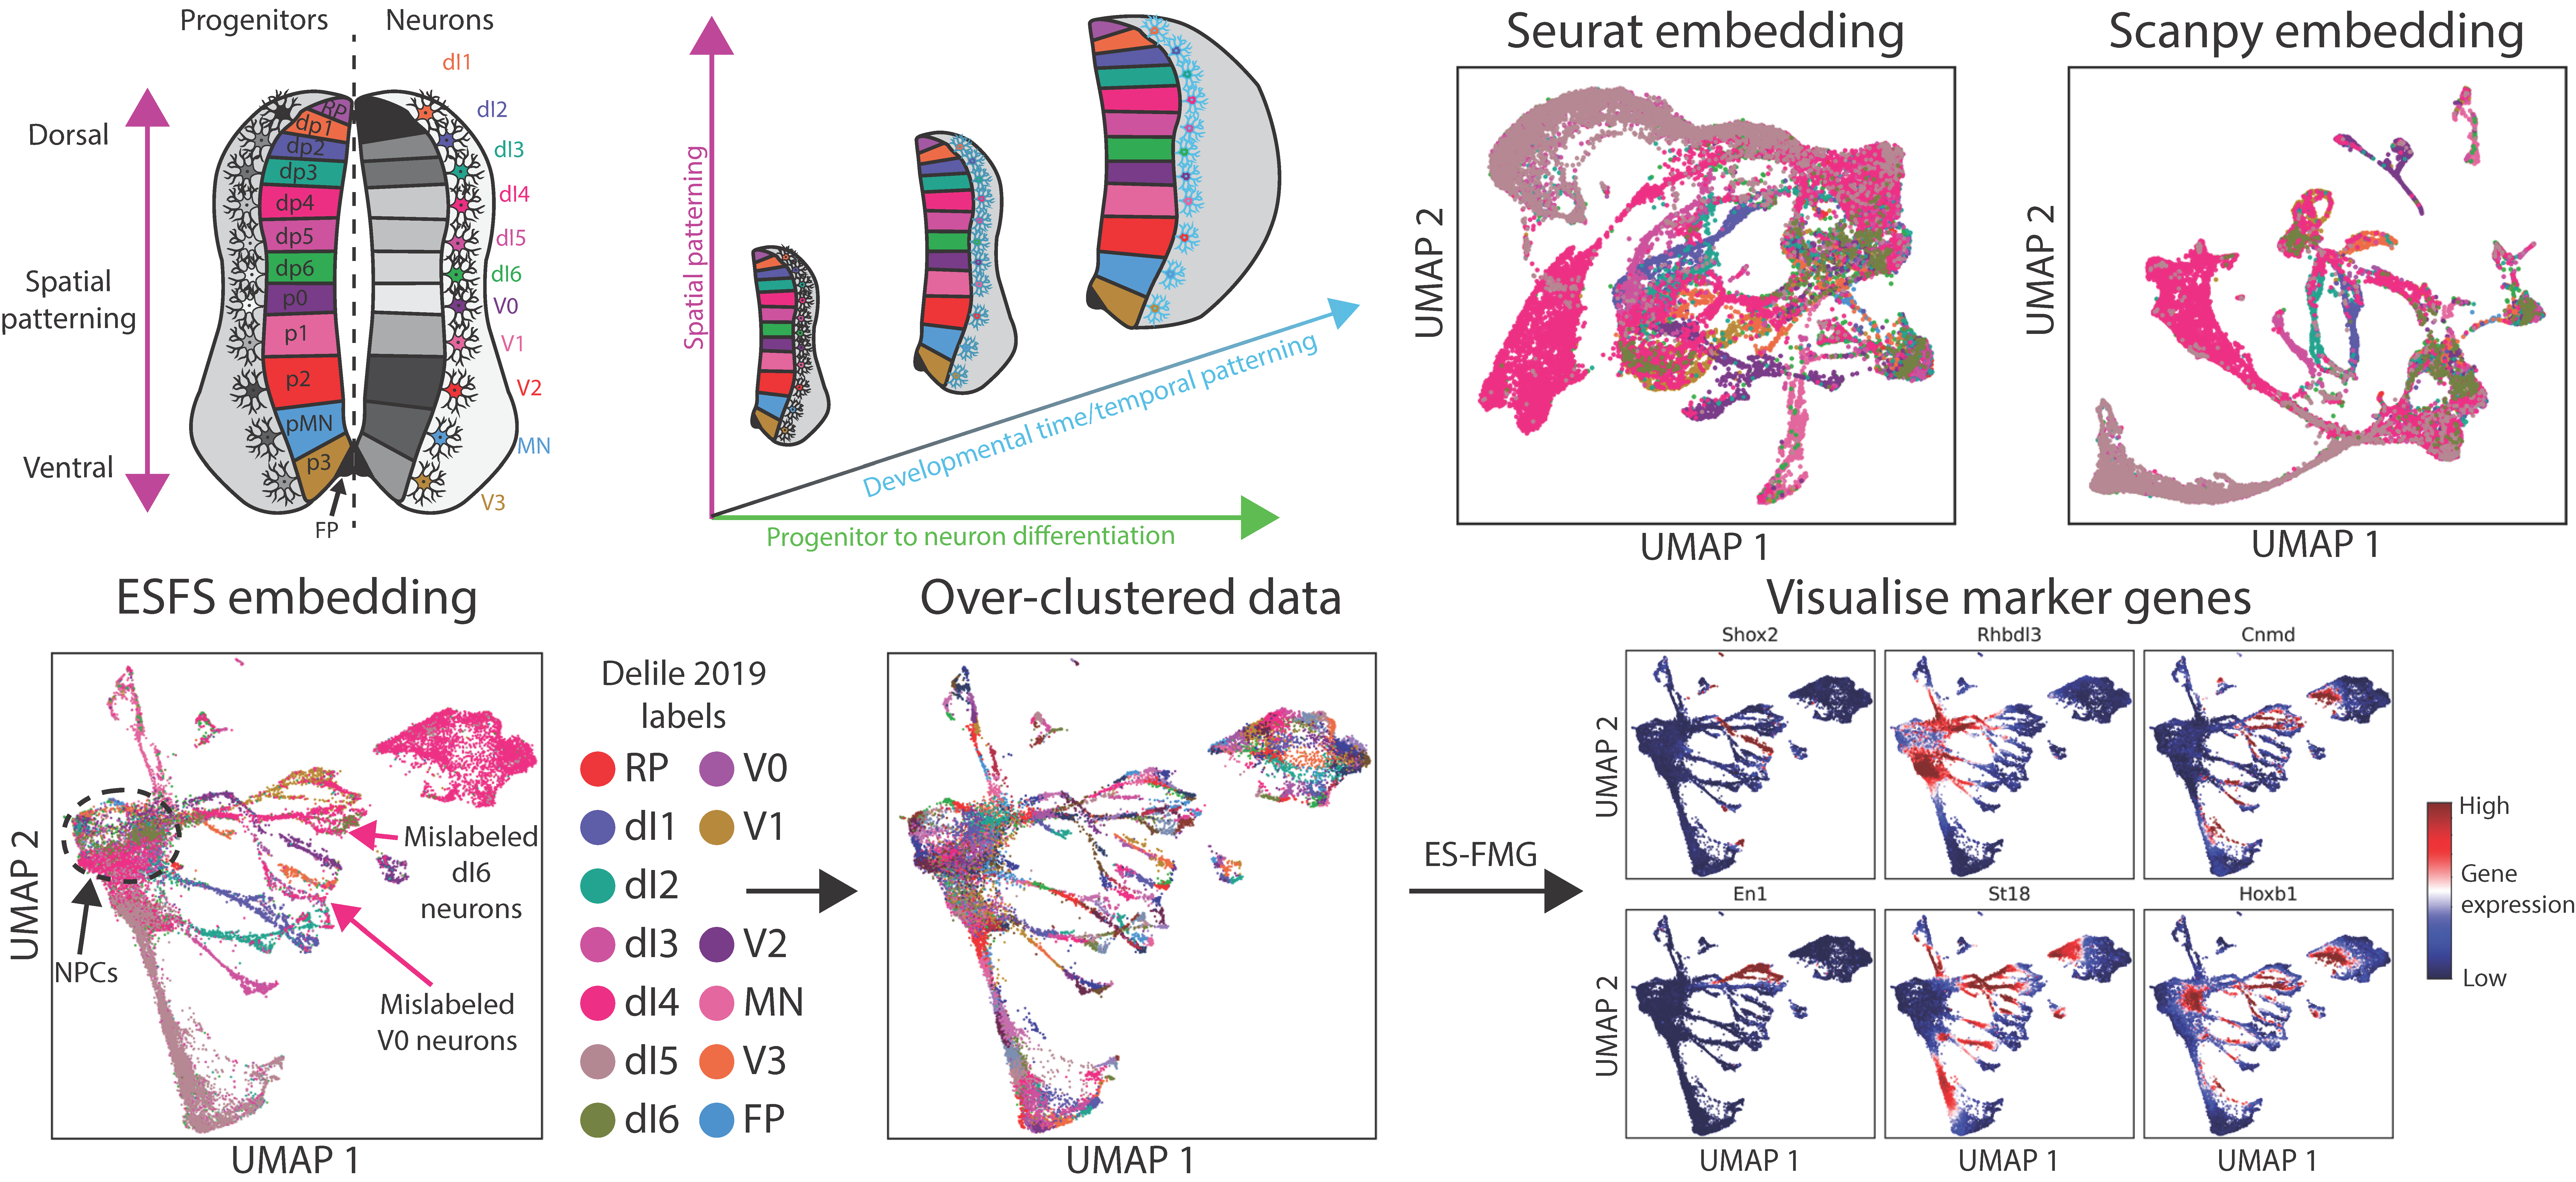

In [2]:
from IPython.display import Image, display
display(Image(filename=path+"Workflow_Image.png"))

### Import ESFS package

In [3]:
import esfs

### Import additional packages

In [96]:
import plotly.express as px
from scipy.sparse import csc_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import FuncNorm
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.stats import pearsonr
from matplotlib import colors as mcolors
from matplotlib.colors import to_rgba
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap, Normalize
from  matplotlib.cm import ScalarMappable
import math

### Set python default discrete class colour palette to one with more colours

In [5]:
Colours = px.colors.qualitative.Dark24
Colours.remove('#222A2A') # Remove black form the color palette (personal preference).
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=Colours)

### Load early human embryo scRNA-seq data and sample info

In [6]:
adata = ad.read_h5ad(path+"ES_adata.h5ad")

### Create and save a scaled version of the scRNA-seq counts matrix
Create and save a scaled version of the scRNA-seq counts matrix where each genes has their observed expression values clipped if above a percentile threshold (default=97.5) and are then normalised by their maximum values so that all values are between 0-1, which is a requirment for the Entropy Sort Score (ESS) and Error Potential (EP) calcualtions.

In [9]:
adata = esfs.Create_Scaled_Matrix(adata)

Scaled expression matrix has been saved to 'adata.layers['Scaled_Counts']' as a sparse csc_matrix


### Calculate ESS and EP matricies
Here we use the theory of Entropy Sorting to generate a pairwise gene correlation matrix (ESS matrix) and a correlation significance matrix (EP matrix). To speed up calculations parallel processing is implemented. To control the number of cores used for processing, vary the "Use_Cores" parameter which deaults to "Use_Cores=-1" which indicates the software will use n-1 cores, where n is the number of cores available on your machine. 
Please note that "Use_Cores=-1" is as special flag and "Use_Cores=-2" will not use n-2 cores. You should instead change "Use_Cores" to positive integer values of the number of cores you would like to use.

In [10]:
adata = esfs.Parallel_Calc_ES_Matricies(adata, Secondary_Features_Label="Self", save_matrices=np.array(["ESSs","EPs"]), Use_Cores=-1)

Cores Available: 16
Cores Used: 15
Calculating ESS and EP matricies.
If progress bar freezes consider increasing system memory or reducing number of cores used with the 'Use_Cores' parameter as you may have hit a memory ceiling for your machine.


  0%|          | 0/15933 [00:00<?, ?it/s]

ESSs for Self label have been saved to 'adata.varm['Self_ESSs']'
EPs for Self label have been saved to 'adata.varm['Self_EPs']'


### Calculate gene importance rankings
We now calculate the gene importance weights and hence gene importance rankings for the remaining genes in the dataset. For further details see our manuscript.

In [11]:
### An array of known important genes for early human embryo development so that we may use them as a
# reference point for how genes are beign ranked/grouped. Replace these genes with those you are
# interested in in your data.
Known_Important_Genes = np.load(path+"Delile2019_Knowledge_Matrix_Genes.npy")

### Run the ES_Rank_Genes function while using "Exclude_Genes=Exclude_Batch_Effect_Genes" to exclude possible
# batch effect genes and "Known_Important_Genes=Known_Important_Genes" as reference point genes.
adata = esfs.ES_Rank_Genes(adata,Known_Important_Genes=Known_Important_Genes)

Pruning ESS graph by removing genes with with low numbers of edges (Min_Edges = 5)
Starting genes = 15933
Remaining genes = 8810
Remaining genes = 8639
Remaining genes = 8596
Remaining genes = 8580
Remaining genes = 8569
Remaining genes = 8563
Remaining genes = 8558
Remaining genes = 8552
Remaining genes = 8549
Remaining genes = 8548
Caclulating feature weights
Known inportant gene ranks:
      Cplx2   Ezr  Fam210b  Gm26801  Insm1  Ly6e  Mfap2  Mfng   Pam  Sstr2  \
Rank   3047  4016      NaN     2487    233  6927   3799  1786  5110    612   

      ...  Ebf2  Eya2  Fam110a  Gm26801  Igfbp2  Igsf8  Mfng  Olig3  Plk3  \
Rank  ...  2657  1617     4808     2487    6164   3941  1786    104  1140   

      Sstr2  
Rank    612  

[1 rows x 829 columns]
ESFS gene weights have been saved to 'adata.var['ESFS_Gene_Weights']'
ESFS gene ranks have been saved to 'adata.var['ES_Rank']'


### Visualise clustering of top ranked genes in a UMAP generated from their pairwise ESS scores

Visualising the ESS graph of the top 2500 ranked genes in a UMAP.
Clustering == an integer value leading to Kmeans clustering, set Clustering to 'hdbscan' for automated density clustering.
This function outputs the 'Top_ESS_Genes', 'Gene_Clust_Labels' and 'Gene_Embedding' objects in case users would like to investiage them further.


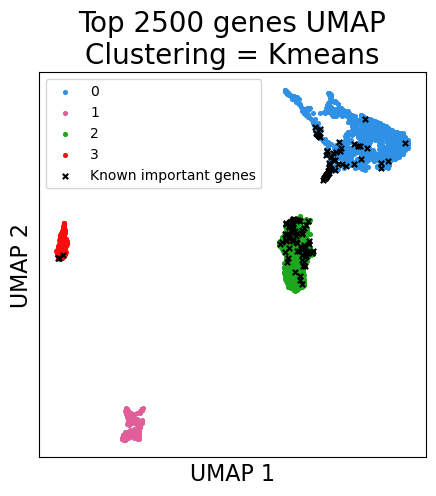

In [14]:
### Visualise top ranked genes graph
# Num_Top_Ranked_Genes is the second of the two paramaters that users should focus on when optimising
# the ESFS workflow for their data. Values between 3000-4000 are a typically good place to start.
Num_Top_Ranked_Genes = 2500

# The "Clustering" paramter can be set to an integer value if you wish to cluster genes in the UMAP with Kmeans clustering.
# Set "Clustering='hdbscan'" for automated density based clustering, and "Clustering=None" for no clustering.
# In this example we set "Clustering=4" to demonstrate the application of kMeans clustering, but hdbscan would
# work similarly in this scenario.
Top_ESS_Genes, Gene_Clust_Labels, Gene_Embedding = esfs.Plot_Top_Ranked_Genes_UMAP(adata,Num_Top_Ranked_Genes,Clustering=4,Known_Important_Genes=Known_Important_Genes)
plt.show()

### Visualise the cell clustering UMAPs for each of the groupings of genes identified in the previous step

This is stage of the worfklow is a critical step for trying out different input parameters to try and optimise the final results. The 2 main paramters to vary are the "Num_Top_Ranked_Genes" and the "Clustering" inputs for the Plot_Top_Ranked_Genes_UMAP function.

In breif, you are seeking a gene cluster or combination of gene cluster that reveal biological structure of interest by excluding clusters of genes that contribute a large amount of noise to downstream analysis.

In [16]:
### Get the cell UMAPs for each cluster of genes identified via the Plot_Top_Ranked_Genes_UMAP function.
# n_neighbors: Number of nearest neighbours and min_dist paramaters used for each cell UMAP.
# log_transformed: Determines whether the counts matrix is log2 transcformed (True) or not (False) before generating UMAPs.
# metric: The distance metric used for cell UMAP creation. Default is "correlation" 
# and we highly recommend "correlation" or "cosine", but you may try others.
Gene_Cluster_Embeddings, Gene_Cluster_Selected_Genes = esfs.Get_Gene_Cluster_Cell_UMAPs(adata,Gene_Clust_Labels,Top_ESS_Genes,n_neighbors=50,min_dist=0.1,log_transformed=True)

Generating the cell UMAP embeddings for each cluster of genes from the previous function.
Plotting cell UMAP using gene clusters 0
Plotting cell UMAP using gene clusters 1
Plotting cell UMAP using gene clusters 2
Plotting cell UMAP using gene clusters 3


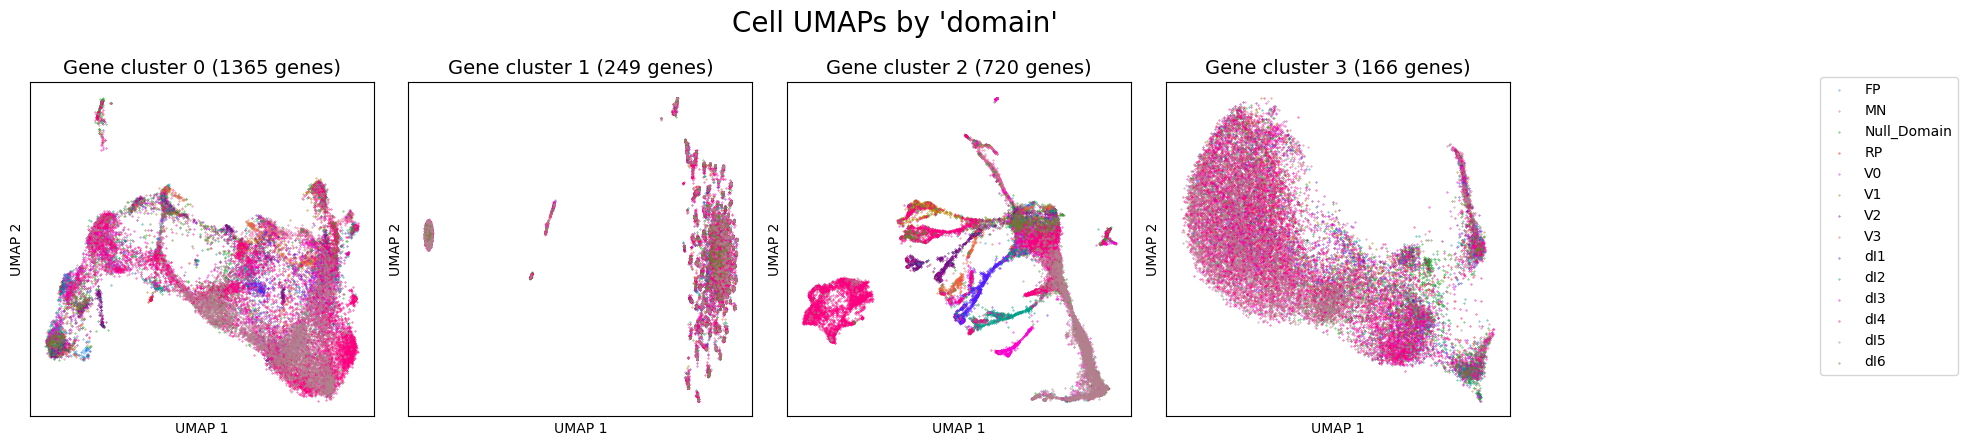

In [18]:
# Plot the cell UMAPs for each gene cluster.
esfs.Plot_Gene_Cluster_Cell_UMAPs(adata,Gene_Cluster_Embeddings,Gene_Cluster_Selected_Genes,Cell_Label="domain",
    ncol=4,figsize=(18, 4.5),marker_size=0.1,log2_Gene_Expression=True)
plt.show()

### If you'd like to generate the cell UMAP for a specific cluster of a combination or clusters, use the specific_cluster parameter

For this workflow we find cluster 1 to be produce the most distinct and informative UMAP, so we use "specific_cluster=[1]".

In [19]:
Gene_Cluster_Embeddings, Gene_Cluster_Selected_Genes = esfs.Get_Gene_Cluster_Cell_UMAPs(adata,Gene_Clust_Labels,Top_ESS_Genes,specific_cluster=[2],n_neighbors=50,min_dist=0.1,log_transformed=True)

Generating the cell UMAP embeddings for each cluster of genes from the previous function.
Plotting cell UMAP using gene clusters [2]


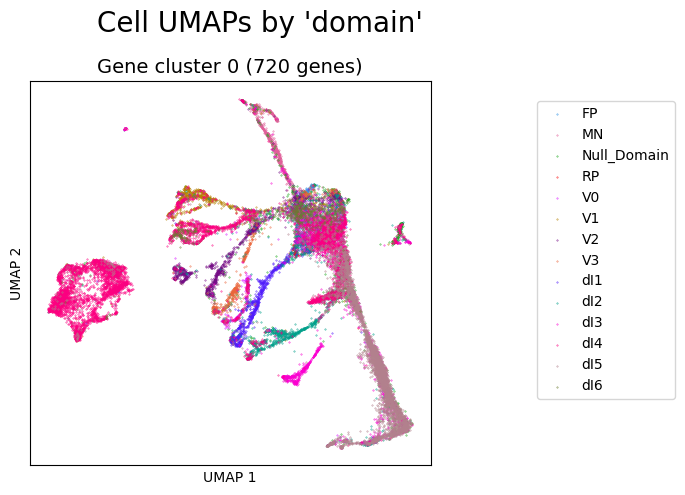

In [23]:
# Plot the cell UMAPs for each gene cluster.
esfs.Plot_Gene_Cluster_Cell_UMAPs(adata,Gene_Cluster_Embeddings,Gene_Cluster_Selected_Genes,Cell_Label="domain",
    ncol=1,figsize=(5.3, 5),marker_size=0.1,log2_Gene_Expression=True)
plt.show()

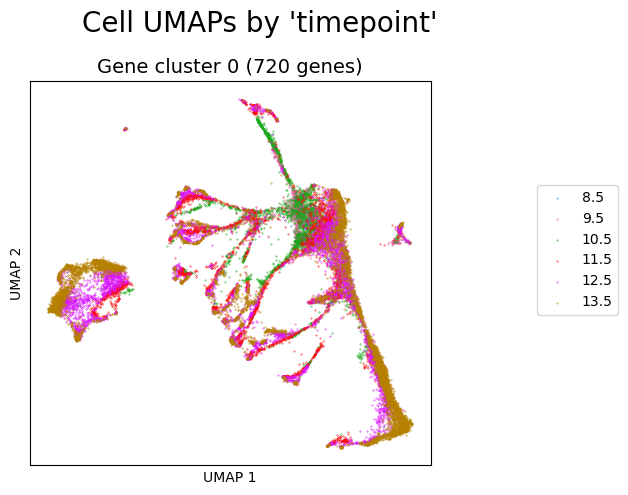

In [85]:
# Plot the cell UMAPs for each gene cluster.
esfs.Plot_Gene_Cluster_Cell_UMAPs(adata,Gene_Cluster_Embeddings,Gene_Cluster_Selected_Genes,Cell_Label="timepoint",
    ncol=1,figsize=(5.3, 5),marker_size=0.1,log2_Gene_Expression=True)
plt.show()

In [24]:
# Retain ES-GSS selected genes and resuting cel UMAP embedding
ES_GSS_Genes = Gene_Cluster_Selected_Genes[0].copy()
ES_UMAP_Embedding = Gene_Cluster_Embeddings[0].copy()

In [25]:
## For plotting, we often use the kNN smoothed expression. Using this function we can get the smoothed counts
# matrix according to the cell neighbourhoods in the gene expression space, sub-setted to the ES_GSS_Genes
adata = esfs.knn_Smooth_Gene_Expression(adata, ES_GSS_Genes, knn=50, metric='correlation', log_scale=False)

Computing batched correlation distances for 25135 cells, batch size = 1000
Smoothing expression matrix using mean over 50 neighbors...
Smoothed expression with knn = 50 saved to adata.layers['Smoothed_Expression']


### ES Marker Gene Selection

Having identified a set of genes that improves cell type seperation, we will use the use the Entropy Sorting Combinatorial Cluster Finder (ES-CCF) and Entropy Sorting Find Marker Gene (ES-FMG) algorithms to find a small set of marker genes that are optimised to capture distinct cell states.

In [ ]:
# For this neural tube dataset, we found Leiden clustering struggled to partition the distinct sub-branches in
# the samples within each interneuron spatial domain in the UMAP space. As such we employed hierarchical clustering
# with the below code.
 
from fastcluster import linkage
from sklearn.base import TransformerMixin
from scipy.cluster.hierarchy import fcluster

class CorrelationScaler(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_centered = X - X.mean(axis=1, keepdims=True)
        norms = np.linalg.norm(X_centered, axis=1, keepdims=True)
        return X_centered / norms

In [28]:
sub_adata = adata[:, ES_GSS_Genes]
sub_adata.X = np.log2(sub_adata.X.A+1)
X_scaled = CorrelationScaler().fit_transform(sub_adata.X.A)
Z = linkage(X_scaled, method='ward')

/var/folders/r9/cmjg8gtj47xd5r03cdvsq6wr0000gp/T/ipykernel_8602/2298471399.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  sub_adata.X = np.log2(sub_adata.X.A+1)


In [29]:
# Get cluster labels for desired number of clusters
Clusts = fcluster(Z, t=250, criterion='maxclust')

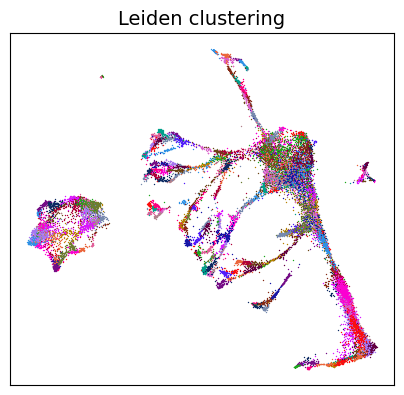

In [58]:
## Sometimes randomly shuffling the Unique_Leiden_Clusts IDs before plotting (to change cluster label colours)
# can help us better visualise the over-clustering.
Unique_Clusts = np.unique(Clusts)
np.random.shuffle(Unique_Clusts)

plt.figure(figsize=(4,4))
plt.title("Leiden clustering",fontsize=14)
for i in np.arange(Unique_Clusts.shape[0]):
    Inds = np.where(Clusts == Unique_Clusts[i])[0]
    plt.scatter(ES_UMAP_Embedding[Inds,0],ES_UMAP_Embedding[Inds,1],s=1,linewidths=0)

plt.xticks([])
plt.yticks([]) 
#
plt.subplots_adjust(0.02,0.02,0.98,0.9)

# Re-set the Unique_Leiden_Clusts labels
Unique_Clusts = np.unique(Clusts)
plt.show()

Now we use the Leiden clusters as the input for ES-CCF to identify sets of samples/cells that maximise the correlation of each feature/gene in adata object.

By default the esfs.Parallel_Calc_ES_Matricies function calculates ES metrics of each feature in adata against each feature in adata (pairwise). However, esfs.Parallel_Calc_ES_Matricies may also be provided a set of "Secondary_Features", where each of these Secondary_Features will have ES metrics calculated pairwise against each feature in the adata object. Hence we refer to the Leiden cluster labels as secondary features.

In [40]:
# The Secondary_Features_Label will be used as a prefix to save resulting ES metrics to the adata object.
Secondary_Features_Label = "Clusts_Secondary_Features"
# Using the pd.get_dummies function we convert the Leiden_Clusts vector into a one-hot representation where each 
# unique label becomes it's own feature of 0's and 1's.
Clusts_Secondary_Features = csc_matrix(pd.get_dummies(Clusts).astype("f"))
adata.obsm[Secondary_Features_Label] = Clusts_Secondary_Features

We use Parallel_Calc_ES_Matricies to calculate the required metrics for ES combinatorial marker gene identification (save_matrices=np.array(["ESSs","SGs"])). 
Secondary_Features_Label designates a prefix for saving the ESS and SG outputs.

In [41]:
adata = esfs.Parallel_Calc_ES_Matricies(adata, Secondary_Features_Label=Secondary_Features_Label, save_matrices=np.array(["ESSs","SGs"]), Use_Cores=-1)

You have provided a 'Secondary_Features_Label', implying that in the anndata object there is a corresponding csc_sparse martix object with rows as samples and columns as features. Each feature will be used to calculate ES scores for each of the variables of the adata object
Cores Available: 16
Cores Used: 15
Calculating ESS and EP matricies.
If progress bar freezes consider increasing system memory or reducing number of cores used with the 'Use_Cores' parameter as you may have hit a memory ceiling for your machine.


  0%|          | 0/250 [00:00<?, ?it/s]

ESSs for Clusts_Secondary_Features label have been saved to 'adata.varm['Clusts_Secondary_Features_ESSs']'
SGs for Clusts_Secondary_Features label have been saved to 'adata.varm['Clusts_Secondary_Features_SGs']'


With the ESS and SG matricies saved to adata, we can use the ES_CCF function to identify which combination of Clusters maximises the correlation (ESS) or each feature/gene in adata. The main output of ES_CCF is a 2D array where each row is the samples of adata and each column is a feature representing the identified combination of Clusters that maximises the ESS score of the respective feature/gene column in adata.

The ES_CCF function prints where the ES_CCF outputs are saved in the adata object.

In [42]:
adata = esfs.ES_CCF(adata,Secondary_Features_Label)

For this function to work, you must have ran the Parallel_Calc_ES_Matricies function in a manner that attaches ESS and SG objects to your adata object that relate to your Secondary_Features_Label label.
Cores Available: 16
Cores Used: 15
Calculating ESS and EP matricies.
If progress bar freezes consider increasing system memory or reducing number of cores used with the 'Use_Cores' parameter as you may have hit a memory ceiling for your machine.


  0%|          | 0/15933 [00:00<?, ?it/s]

Max combinatorial ESSs for given sample labels has been saved as 'adata.varm['Clusts_Secondary_Features_Max_Combinatorial_ESSs']'
The features/clusters relating to each Max_ESS have been saved in 'adata.obsm['Clusts_Secondary_Features_Max_ESS_Features']'


#### Visualise Max ESS clusters
With the below script, you may select a gene and visualise the corresponding Max ESS cluster identified by the ES-CCF algorithm as maximally correlating/enriching the genes expression values in a group samples.

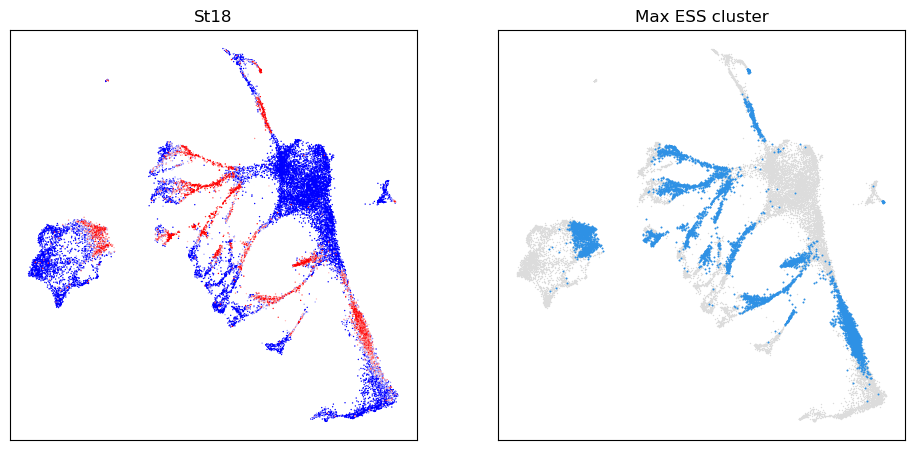

In [ ]:
###
Gene = "Sox2" # "Arid3a", "Cnmd", "Neurod6", "St18"
###
Gene_Ind = np.where(adata.var_names == Gene)[0]
Inds = np.where(adata.obsm['Clusts_Secondary_Features_Max_ESS_Features'][:,Gene_Ind].A == 1)[0]
plt.figure(figsize=(4.66*2,2.33*2))
plt.subplot(1,2,1)
plt.title(Gene,fontsize=12)
Exp = np.asarray(adata[:,Gene].X.A).ravel()
Exp = np.clip(Exp,a_min=0,a_max=np.percentile(Exp,97.5))
Order = np.argsort(Exp)
plt.scatter(ES_UMAP_Embedding[Order,0],ES_UMAP_Embedding[Order,1],c=Exp[Order],s=1,cmap="bwr",linewidths=0)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.title("Max ESS cluster",fontsize=12)
plt.scatter(ES_UMAP_Embedding[:,0],ES_UMAP_Embedding[:,1],s=1,c="gainsboro",linewidths=0)
plt.scatter(ES_UMAP_Embedding[Inds,0],ES_UMAP_Embedding[Inds,1],s=2,linewidths=0)
plt.xticks([])
plt.yticks([])
#
plt.subplots_adjust(0.02,0.02,0.98,0.9)

plt.show()

The 2D array of combined Clusters that maximise adata feature/gene ESSs is then used by Parallel_Calc_ES_Matricies as set of secondary features to obtain the ESS scores of each feature/gene in adata against each identified structure maximising feature. This creates a 2D pairwise adata feature/gene Vs coarse grain combined Cluster correlation matrix.

Plainly, we obtain a correlation matrix that quantifies how well each gene correlates to the ES-CCF optimised clusters for each gene. These correlations act as a proxy for where are best enriched in the combinatorial cluster space of the intentionally over-clustered data.

In [44]:
Secondary_Features_Label = "Clusts_Secondary_Features_Max_ESS_Features"
adata = esfs.Parallel_Calc_ES_Matricies(adata, Secondary_Features_Label=Secondary_Features_Label, save_matrices=np.array(["ESSs"]), Use_Cores=-1)

You have provided a 'Secondary_Features_Label', implying that in the anndata object there is a corresponding csc_sparse martix object with rows as samples and columns as features. Each feature will be used to calculate ES scores for each of the variables of the adata object
Cores Available: 16
Cores Used: 15
Calculating ESS and EP matricies.
If progress bar freezes consider increasing system memory or reducing number of cores used with the 'Use_Cores' parameter as you may have hit a memory ceiling for your machine.


  0%|          | 0/15933 [00:00<?, ?it/s]

ESSs for Clusts_Secondary_Features_Max_ESS_Features label have been saved to 'adata.varm['Clusts_Secondary_Features_Max_ESS_Features_ESSs']'


### ES-FMG
Now that we have a coarse grain represenation of where gene structure is maximised in different regions of the data, we can use esfs.ES_FMG to identify a minimal set of clusters/genes that captures that most unique/non-overlapping structure in the data. This minimal gene set may be thought of as an optimised set of unsuperised marker genes.

In [45]:
Num_Genes = 400
Chosen_Clusters, Chosen_Genes, Chosen_Pairwise_ESSs = esfs.ES_FMG(adata,Num_Genes,Secondary_Features_Label,Resolution=1,Num_Reheats=3)

Cores Available: 16
Cores Used: 15
Current highest score: 6.08727183256485
Current highest score: 6.609658263141608
Current highest score: 7.091742998830481
Current highest score: 7.559024442764044
Current highest score: 7.993946214478045
Current highest score: 8.355494734673911
Current highest score: 8.696225664508422
Current highest score: 9.029883016763897
Current highest score: 9.326262118119095
Current highest score: 9.627444832555046
Current highest score: 9.90381167081432
Current highest score: 10.149099170572233
Current highest score: 10.392002189280204
Current highest score: 10.632659055407487
Current highest score: 10.863704830661462
Current highest score: 11.085751998605497
Current highest score: 11.303397554300847
Current highest score: 11.519130555721992
Current highest score: 11.73317755505693
Current highest score: 11.951793129961974
Current highest score: 12.159067088631376
Current highest score: 12.35625757696339
Current highest score: 12.547928094630954
Current highes

ES-FMG produces 3 outputs:
 
Chosen_Genes - The optimised set of N marker genes.

Chosen_Clusters - The Max ESS cluster indicies. Subsetting all adata genes to the Chosen_Clusters inds should yeild the same output as Chosen_Genes (adata.var_names[Chosen_Clusters]).

Chosen_Pairwise_ESSs - A pairwise matrix of the Chosen genes and their ESSs with the corresponding Max ESS clusters. The diadonal of this matrix is the ESS of the given marker gene with its Max ESS cluster.

#### Data visualisation
Now that we have a set of optimised marker genes, we may visualise and interpret the results. Below is a simple script to visualise expression in the UMAP space.

We recommend saving plots for each of the ES-FMG "Chosen_Genes" and inspecting them to visualise where the optimised set of marker genes capture different populations of samples.

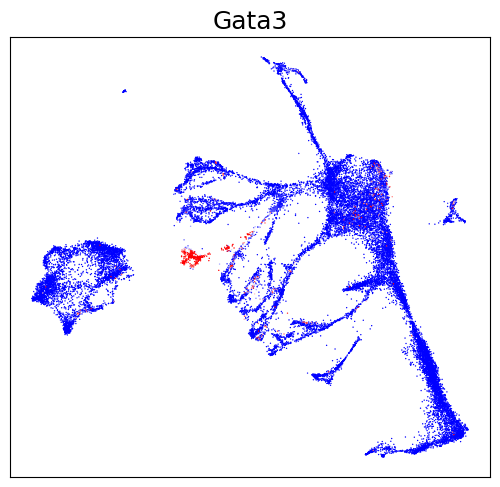

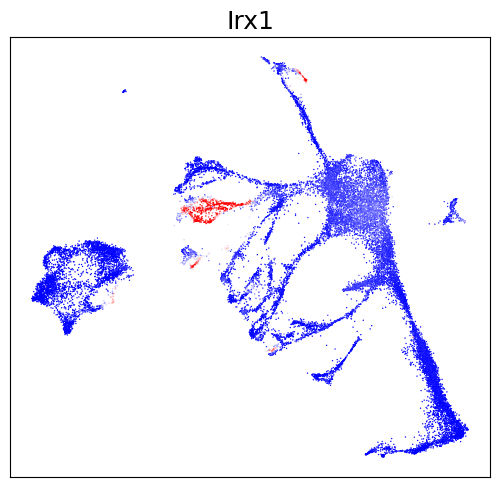

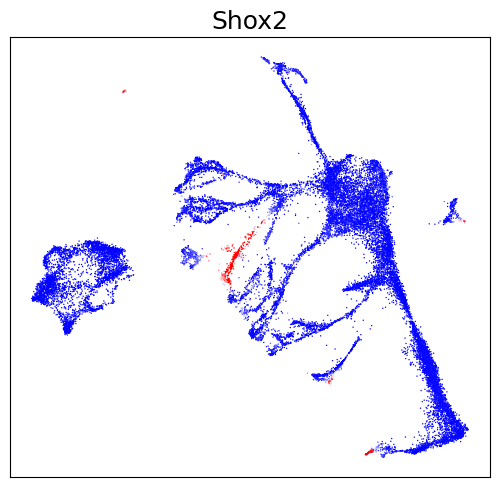

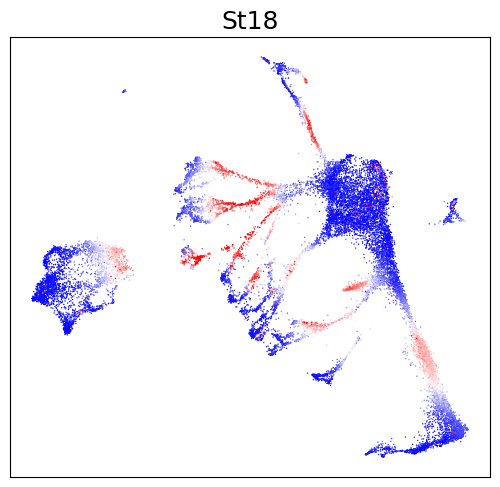

In [115]:
###
Plot_Genes = np.array(["Gata3","Irx1","Shox2","St18"])
###

###
# plot_save_path = "" Edit and uncomment to set the save path for plots
# Plot_Genes = Chosen_Genes.copy()
###

for i in np.arange(Plot_Genes.shape[0]):
    Gene = Plot_Genes[i]
    plt.figure(figsize=(5,5))
    #
    plt.title(Gene,fontsize=18)
    # Exp = np.asarray(adata[:,Gene].X.A).ravel()
    Exp = np.asarray(adata[:,Gene].layers["Smoothed_Expression"].A).ravel()
    Exp = np.clip(Exp,a_min=0,a_max=np.percentile(Exp,99))
    Order = np.argsort(Exp)
    plt.scatter(ES_UMAP_Embedding[Order,0],ES_UMAP_Embedding[Order,1],c=Exp[Order],s=1,linewidths=0,cmap="bwr")
    plt.xticks([])
    plt.yticks([])
    #
    plt.subplots_adjust(0.02,0.02,0.98,0.9)
    #
    # plt.savefig(plot_save_path + Gene + ".png",dpi=600)
    # plt.close()

plt.show()

### Save results
Some suggested objects to save for reproducibility (un-comment to use).

In [ ]:
# # The adata object with saved ES arrays
# adata.write_h5ad(path+"ES_adata.h5ad",compression='gzip')
# # The cell UMAP embedding
# np.save(path+"ES_UMAP_Embedding.npy",ES_UMAP_Embedding)
# # The ES-GSS gene set that produced the cell UMAP embedding
# np.save(path+"ES_GSS_Genes.npy",ES_GSS_Genes)
# # The Leiden clusters generated during intentional over-clustering
# np.save(path+"Leiden_Clusts.npy",Leiden_Clusts)
# # The optimised gene set selected by ES-FMG
# Chosen_Genes = np.load(path+"ES_FMG_Marker_Genes.npy")
# # The optimised gene set indices/Max ESS cluster indices selected by ES-FMG
# Chosen_Clusters = np.load(path+"ES_FMG_Chosen_Clusters.npy")

### Multi-gene plots

In [ ]:
## A provided function to plot multiple genes ona. single embedding.

def plot_gene_expression_on_umap(Genes, Cell_Type_Colours, ES_UMAP_Embedding, adata, ax, fig):
    # --- FILTER EMPTY GENES
    mask = Genes != ""
    Genes = Genes[mask]
    Cell_Type_Colours = Cell_Type_Colours[mask]

    n_cells = ES_UMAP_Embedding.shape[0]
    n_genes = Genes.size

    expr = np.zeros((n_genes, n_cells))
    prctl = np.zeros_like(expr)

    # --- COLLECT EXPRESSION & PERCENTILE RANKS
    for gi, gene in enumerate(Genes):
        e = np.asarray(adata[:, gene].layers["Smoothed_Expression"].A).ravel()
        e = np.clip(e, 0, np.percentile(e, 97.5))
        expr[gi] = e
        ranks = e.argsort().argsort()
        prctl[gi] = ranks / (n_cells - 1)

    # --- IDENTIFY BEST GENE PER CELL
    best_gene_idx = prctl.argmax(axis=0)
    expr = expr / np.max(expr, axis=1).reshape(n_genes, 1)
    non_zero_mask = expr.sum(axis=0) > 0
    cells_to_plot = non_zero_mask

    # --- BUILD GLOBAL PLOTTING TABLE
    rows = []
    for i in range(n_cells):
        if not cells_to_plot[i]:
            continue
        gi = best_gene_idx[i]
        gene = Genes[gi]
        color = Cell_Type_Colours[gi]
        perc = prctl[gi, i]
        vals = expr[gi, i]

        rows.append({
            "x": ES_UMAP_Embedding[i, 0],
            "y": ES_UMAP_Embedding[i, 1],
            "percentile": perc,
            "gene": gene,
            "color": color,
            "vals": vals
        })

    df = pd.DataFrame(rows)

    # --- SORT BY PERCENTILE SO HIGH VALUES ARE ON TOP
    df.sort_values("vals", inplace=True)

    # --- MAP PERCENTILE TO RGBA (black → gene color)
    def interpolate_black_to_color(color, value):
        rgba = np.array(to_rgba(color))
        rgb = rgba[:3]
        interpolated_rgb = value[:, None] * rgb
        alpha = np.ones_like(value)
        return np.concatenate([interpolated_rgb, alpha[:, None]], axis=1)

    percentiles = df["vals"].values.astype(float)
    colors_hex = df["color"].values

    rgba_colors = np.array([
        interpolate_black_to_color(color, np.array([v]))[0]
        for color, v in zip(colors_hex, percentiles)
    ])

    # --- PLOT ALL IN ONE CALL
    marker = "o"
    m_size = 1

    ax.scatter(df["x"].values, df["y"].values,
               s=m_size,
               marker=marker,
               c=rgba_colors,
               linewidths=0)

    # --- AXIS CLEANUP
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-2.5, 14)
    ax.set_ylim(-3.5, 16.8)

    # --- COLORBARS FOR EACH GENE
    mappables = []
    for gene, color in zip(Genes, Cell_Type_Colours):
        rgba = to_rgba(color)
        cmap = LinearSegmentedColormap.from_list(f"{gene}_map", ["black", rgba])
        norm = Normalize(vmin=0, vmax=1)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        mappables.append((sm, gene))

    # --- MULTI-COLUMN COLORBAR LAYOUT
    n_bars = len(mappables)
    bars_per_column = 4
    n_columns = math.ceil(n_bars / bars_per_column)

    bar_w = 0.02
    bar_h = 0.2
    v_spacing = 0.06
    horizontal_spacing = 0.12

    fig.subplots_adjust(right=0.82 + n_columns * (bar_w + horizontal_spacing))

    for col_idx in range(n_columns):
        start_idx = col_idx * bars_per_column
        end_idx = min(start_idx + bars_per_column, n_bars)
        col_mappables = mappables[start_idx:end_idx]

        n_this_col = len(col_mappables)
        total_height = n_this_col * bar_h + (n_this_col - 1) * v_spacing
        y_top = 0.5 + total_height / 2

        for row_idx, (sm, gene) in enumerate(col_mappables):
            y0 = y_top - (row_idx + 1) * bar_h - row_idx * v_spacing
            x0 = 1.02 + col_idx * (bar_w + horizontal_spacing)

            cax = ax.inset_axes([x0, y0, bar_w, bar_h], transform=ax.transAxes)
            cb = fig.colorbar(sm, cax=cax)
            cb.set_ticks([cb.norm.vmin, cb.norm.vmax])
            cb.set_ticklabels([f"{cb.norm.vmin:.2f}", f"{cb.norm.vmax:.2f}"])
            cb.ax.set_ylabel(gene,
                             rotation=270, labelpad=-20,
                             va='bottom', fontsize=7)
            cb.ax.tick_params(labelsize=6)

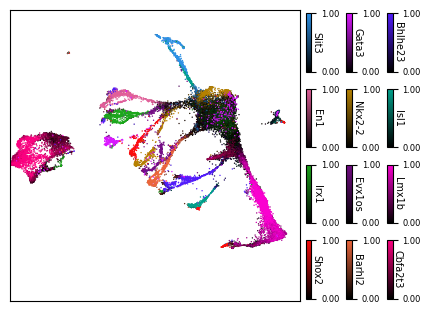

In [103]:
# # Spatial
Genes = np.array(["Slit3","En1","Irx1","Shox2","Gata3","Nkx2-2","Evx1os","Barhl2","Bhlhe23","Isl1","Lmx1b","Cbfa2t3"])#,"Shh","Lmx1a"])
Cell_Type_Colours = np.asarray(Colours)[np.arange(Genes.shape[0])]
fig, ax = plt.subplots(figsize=(2.6, 3.7783783783783784))

plot_gene_expression_on_umap(Genes, Cell_Type_Colours, ES_UMAP_Embedding, adata, ax, fig)

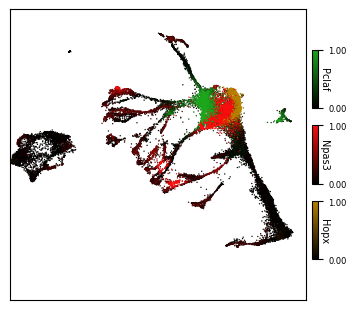

In [107]:
# # Temporal
Cell_Type_Colours = np.array(["#1CA71C","#FB0D0D","#B68100"])
# Genes = np.array(["Cnmd","Zfhx4","Neurod6"]) # Neuron temporal
Genes = np.array(["Pclaf","Npas3","Hopx"]) # Progenitor temporal
# Genes = np.array(["Hoxb1","Mn1","Gm17750"]) # Neuron + progenitor temporal
fig, ax = plt.subplots(figsize=(3.55, 3.7783783783783784))

plot_gene_expression_on_umap(Genes, Cell_Type_Colours, ES_UMAP_Embedding, adata, ax, fig)

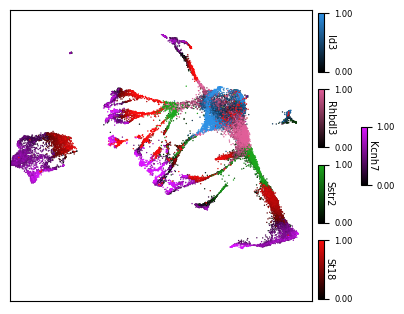

In [101]:
# # Neurogenesis
Genes = np.array(["Id3", "Rhbdl3", "Sstr2", "St18", "Kcnh7"])
Cell_Type_Colours = np.asarray(Colours)[np.arange(Genes.shape[0])]
fig, ax = plt.subplots(figsize=(3.1, 3.7783783783783784))

plot_gene_expression_on_umap(Genes, Cell_Type_Colours, ES_UMAP_Embedding, adata, ax, fig)

### Extracting Ranked Gene Lists for Each Max ESS Cluster

Each gene selected by ES-FMG is associated with an optimised cluster, as determined by the ES-CCF algorithm. This allows us to generate a ranked list of additional genes that co-segregate into the same cellular subpopulation—i.e., genes that share similar expression patterns within the same Max ESS cluster. In practice, after using ES-FMG to identify a set of distinct marker genes, we can retrieve ranked gene lists for each of their corresponding Max ESS clusters to uncover additional genes with closely related spatial or transcriptional profiles.

In [ ]:
## A provided function to retreive a ranked gene list for a set of genes

def get_cluster_ess_rankings(adata, Chosen_Genes):
    """
    Returns:
        Cluster_ESSs_sorted: pd.DataFrame
            DataFrame where each row corresponds to a chosen gene and columns show
            ranked gene names based on ESS values in descending order.
    """
    # Subset the data to the chosen genes
    Sub_Data = adata[:, Chosen_Genes]    
    # Extract the ESS matrix from varm
    Sub_Max_ESS_Clusters = Sub_Data.varm['Leiden_Clusts_Secondary_Features_Max_ESS_Features_ESSs']   
    # Construct the DataFrame of ESS scores
    Cluster_ESSs = pd.DataFrame(
        Sub_Max_ESS_Clusters,
        index=Chosen_Genes,
        columns=adata.var_names
    )    
    # Sort each row (gene) by ESS score in descending order
    Cluster_ESSs_sorted = Cluster_ESSs.apply(
        lambda row: row.sort_values(ascending=False).index.tolist(),
        axis=1
    )    
    # Convert back to DataFrame with ranked columns
    Cluster_ESSs_sorted = pd.DataFrame(
        Cluster_ESSs_sorted.tolist(),
        index=Cluster_ESSs.index,
        columns=[f"Rank_{i+1}" for i in range(Cluster_ESSs.shape[1])]
    )
    return Cluster_ESSs_sorted.T

In [ ]:
## Get ranked gene list
Ranked_Gene_List = get_cluster_ess_rankings(adata, Chosen_Genes)

In [128]:
## Quick inspection
Ranked_Gene_List

Kitl    Pcdh9          Pappa           Cnmd             En1  \
Rank_1        Kitl    Pcdh9          Pappa           Cnmd             En1   
Rank_2      Dnah7b     Syt1         Slc7a8           Npr2         Gm12688   
Rank_3       Rsph9    Reep1        Fam199x  1700039E22Rik             Sp9   
Rank_4      Fam81a     Dtx1            Ret        Gm15413   A830011K09Rik   
Rank_5      Mindy4   Kcnma1           Paox        Gm32335          Fam43a   
...            ...      ...            ...            ...             ...   
Rank_15929  Fbxo44     Heg1       Traf3ip2          Sall3           Med18   
Rank_15930   Tubb3    Baz1a  C130071C03Rik          Zfp39            Zic1   
Rank_15931    Sox4  Rasl11b  4930517O19Rik          Spg11          Zfp110   
Rank_15932   Lzts1    Tead2        Gm13008         Hbb-bt  CAAA01118383.1   
Rank_15933   Scrt2     E2f1        Gm47689        Gm36756            Rsg1   

             Abracl   Neurog2       Adamtsl1  Cntnap5a    Gm4166  ...  \
Rank_1       Abracl   Neurog2       Adamtsl1  Cntnap5a  B4galnt3  ...   
Rank_2      Igf2bp1    Btbd17         Gad1os     Cirbp     Mrvi1  ...   
Rank_3         Ppib   Gadd45g           Gad1      Pfn2   Gm16178  ...   
Rank_4         Naca      Plk3       Cacna2d3     Myt1l   Gm35696  ...   
Rank_5         Rps9   Gm26953           Pax8     Kcnq2      Il11  ...   
...             ...       ...            ...       ...       ...  ...   
Rank_15929    Arl8a    Gpr180           Tank   Slc25a5     Med18  ...   
Rank_15930   Tubb2a  Tmem184b  2610001J05Rik       Ezr   Gm20186  ...   
Rank_15931    Csdc2     Blvra        Gadd45g      Heg1      Slx4  ...   
Rank_15932     Dner     Ssbp4        Rasl11b   Tmem123   Gm15834  ...   
Rank_15933    Magi2      Uap1           Hes6     Tead2     Zfp11  ...   

              Ntrk3       Maf           Cdh8  E130006D01Rik    Wscd2  \
Rank_1        Ntrk3       Maf           Cdh8  E130006D01Rik    Wscd2   
Rank_2         Thra     Cbln2  A330008L17Rik         Mapk11    Gdap1   
Rank_3        Mdga2   St3gal5          Glra2        Onecut2    Snx30   
Rank_4        Oprl1  Arhgef12            Sst          Parvb    Dach2   
Rank_5       Ppfia2     Sgsm1         March4           Ngfr  Onecut2   
...             ...       ...            ...            ...      ...   
Rank_15929    Baz1a     Tead2           H1f0          Bcas1     Yap1   
Rank_15930   Zbtb18   Tmem123           Calr         Prrxl1    Phgdh   
Rank_15931  Slc25a5       Ezr  5930412G12Rik         Gm3764    Nrarp   
Rank_15932     E2f1   Slc25a5         Golim4  C130071C03Rik    Wwtr1   
Rank_15933     Cdk4      Heg1           Rara           Zic1     Rest   

                     Vcan          Lmx1b    Prkg1    Cdh13  Neurod2  
Rank_1               Vcan          Lmx1b    Prkg1    Cdh13  Neurod2  
Rank_2              Ube2b  C130021I20Rik   Camk2d    Lsamp   Pxylp1  
Rank_3               Gopc         Prrxl1     Syt7     Dmtn  Neurod6  
Rank_4              G3bp2           Tlx3   Snhg11    Lrrc7     Cygb  
Rank_5               Gas8        Gm12116  Zdhhc14  Ppp1r1a    Kcnj3  
...                   ...            ...      ...      ...      ...  
Rank_15929        Gm13008           Mycl   Cdkn1c    Stx16    Aif1l  
Rank_15930          Kcnq3          Cmtm4   Phf21b    Rcor2    Mfge8  
Rank_15931        Gm47689          Foxn3    Prox1     Miat     Txn1  
Rank_15932  4930517O19Rik          Ypel1  Gm14964     Tcf4    Acadl  
Rank_15933  C130071C03Rik           Pbx2     Tcf4     Cdk4    Meis2  

[15933 rows x 400 columns]